In [1]:
import numpy as np
from qutip import sigmax, sigmay, sigmaz, qeye, tensor
import matplotlib.pyplot as plt
import pennylane as qml
import sobol_seq  
from concurrent.futures import ThreadPoolExecutor
from scipy.optimize import minimize
import logging
import pickle
import time
import torch
#from optimparallel import minimize_parallel
from scipy.sparse.linalg import eigsh, eigs
import scipy.sparse as sp
import torch.sparse as sparse

In [2]:
def Hmat_Q(n, J, B, index):
    """Constructs the Hamiltonian matrix for the quantum spin system."""
    # Define Pauli matrices
    sx = np.array([[0,1],[1,0]])
    sy = np.array([[0,-1j],[1j,0]])
    sz = np.array([[1,0],[0,-1]])

    # Initialize Sx, Sy, Sz as lists of sparse matrices
    Sx, Sy, Sz = [], [], []
    I = sp.eye(2**n, format="csr")  # Identity matrix for efficiency

    for k in range(n):
        left = sp.eye(2**k, format="csr")  
        right = sp.eye(2**(n-k-1), format="csr")  
        Sx.append(sp.kron(left, sp.kron(sx, right), format="csr"))
        Sy.append(sp.kron(left, sp.kron(sy, right), format="csr"))
        Sz.append(sp.kron(left, sp.kron(sz, right), format="csr"))

    # Interaction term
    H1 = sp.csr_matrix((2**n, 2**n), dtype=np.complex128)
    for i in range(n):
        for j in range(i):
            H1 += index[i, j] * (J[0] * (Sx[i] @ Sx[j]) +
                                 J[1] * (Sy[i] @ Sy[j]) +
                                 J[2] * (Sz[i] @ Sz[j]))

    # Magnetic field term
    H3 = sp.csr_matrix((2**n, 2**n), dtype=np.complex128)
    for i in range(n):
        H3 -= B[0] * Sx[i] + B[1] * Sy[i] + B[2] * Sz[i]

    return H1 + H3


def find_ground_state(n, J, B, index):
    """Computes the ground state and energy using sparse methods."""
    
    H = Hmat_Q(n, J, B, index) 

    # Compute only the lowest eigenvalue and eigenvector using a sparse solver
#    eigenvalues, eigenvectors = eigsh(H, k=1, which="SA")  # Smallest eigenvalue
    eigenvalues, eigenvectors = eigs(H, k=1, which="SR")  # Smallest eigenvalue


    ground_energy = eigenvalues[0]
    ground_state = eigenvectors[:, 0]  # First column is the ground state

    return ground_state, ground_energy

In [3]:
def get_lattice_indices(M, N):
    num_sites = M * N
    indx1 = np.zeros((num_sites, num_sites), dtype=int)
    indx2 = np.zeros((num_sites, num_sites), dtype=int)
    
    def site_index(row, col):
        return (row % M) * N + (col % N)  # Periodic boundary conditions
    
    for row in range(M):
        for col in range(N):
            i = site_index(row, col)
            
            # Nearest neighbors
            neighbors = [
                (row + 1, col),  # Down
                (row - 1, col),  # Up
                (row, col + 1),  # Right
                (row, col - 1)   # Left
            ]
            
            for r, c in neighbors:
                j = site_index(r, c)
                if i != j:  # Avoid self-interaction
                    indx1[i, j] = 1
                
            # Next-nearest neighbors (diagonals)
            diag_neighbors = [
                (row + 1, col + 1),  # Down-Right
                (row + 1, col - 1),  # Down-Left
                (row - 1, col + 1),  # Up-Right
                (row - 1, col - 1)   # Up-Left
            ]
            
            for r, c in diag_neighbors:
                j = site_index(r, c)
                if i != j:  # Avoid self-interaction
                    indx2[i, j] = 1
    
    return indx1, indx2

In [4]:
# Define the custom two-qubit operation
def custom_two_qubit_operation(wires, c1, c2, c3):
    control, target = wires  # Extract control and target qubit indices

    # Entangling operation sequence
    qml.CNOT(wires=[control, target])
    qml.RX(c1, wires=target)
    qml.CNOT(wires=[control, target])
    qml.CNOT(wires=[target, control])
    qml.RZ(c3, wires=target)
    qml.CNOT(wires=[target, control])
    qml.CY(wires=[control, target])
    qml.RY(c2, wires=target)
    qml.CY(wires=[control, target])


# Define the quantum device
def create_device(N):
    return qml.device("default.qubit", wires=N)

# Define the bipartite circuit
def create_qnode(N):
    dev = create_device(N)

    @qml.qnode(dev)
    def circuit(phi1, beta1, phi2, beta2): # the ring is partitioned into pairs of qubits
        # Partition the qubits into even and odd sets
        even_indices = list(range(0, N, 2))  # {0,2,4,6,...}
        odd_indices = list(range(1, N, 2))   # {1,3,5,7,...}
        
        # Apply RX rotation to all qubits
        for i in  range(len(even_indices)):
            qml.RX(phi1, wires=even_indices[i])
        for i in  range(len(odd_indices)):
            qml.RX(phi2, wires=odd_indices[i])


        # Apply RZ rotation to all qubits
        for i in  range(len(even_indices)):
            qml.RZ(beta1, wires=even_indices[i])
        for i in  range(len(odd_indices)):
            qml.RZ(beta2, wires=odd_indices[i])

        return qml.state()  # Return state vector
   
    @qml.qnode(dev)
    def circuit_EO(phi1, beta1, phi2, beta2, c1, c2, c3, rows, cols): # 5-partite 20 spins

        # Partition qubits into even and odd indices
        even_indices = list(range(0, N, 2))  # {0,2,4,6,...}
        odd_indices = list(range(1, N, 2))   # {1,3,5,7,...}

        # Apply RX rotation to all qubits
        for i in even_indices:
            qml.RX(phi1, wires=i)
        for i in odd_indices:
            qml.RX(phi2, wires=i)

        # Construct site index mapping
        site_index = [[0,1,5],[3,4,9],[10,15,16],[14,18,19],[2,6,7,8,11,12,13,17]]
        M11=len(site_index)

        # Apply custom operation to pairs in the even set
        for i in range(M11):  # rows is an integer
            N11=len(site_index[i])
            for j in range(N11-1):  # Iterate properly over column indices
                wires = [site_index[i][j], site_index[i][j+1]]  # Use correct indexing
                custom_two_qubit_operation(wires, c1, c2, c3)   

        # Apply RZ rotation to all qubits
        for i in even_indices:
            qml.RZ(beta1, wires=i)
        for i in odd_indices:
            qml.RZ(beta2, wires=i)

        return qml.state()  # Return state vector

    return circuit, circuit_EO #, circuit_col

#  The ground state for $N = MR \times NC$ spins in an $MR \times NC$ square lattice.

In [5]:
# Finding ground state
# Target ground state for N number of spins
def GS_p(p, r, M1, N1):
    J1 = np.array([-(1 + r) / 2, -(1 - r) / 2, 0])  # nearest-neighbor coupling constant
    B = np.array([0, 0, -p])
    indx1, indx2 = get_lattice_indices(M1, N1)
    N = M1 * N1

    # Find ground state and energy
    ground_state, ground_energy = find_ground_state(N, J1, B, indx1)

    ground_state = ground_state.flatten()
    return ground_state

# Evaluate GE for a range of p values
p_values = np.linspace(0.1, 5, 22)

# Ensure 1, 1.03, and 0.97 are included
required_values = {2.03, 1.97, 2.22, 2.28}
p_values = np.unique(np.append(p_values, list(required_values)))  # Add and remove duplicates

# Sort the array
p_values.sort()

MR=4# Number of rows
NC=5 # Number of columns
NS=MR*NC
psis0 = [GS_p(p, 0, MR, NC) for p in p_values]  # r=0 isotropic XY (or XX) model
psis1 = [GS_p(p, 1, MR, NC) for p in p_values]  # r=1 ising model
psishalf = [GS_p(p, 1/2, MR, NC) for p in p_values]  # r=1/2 XY  model


In [6]:
# Save to a file using pickle
with open('dataXY2D20.pkl', 'wb') as f:
    pickle.dump({'p_values': p_values, 'psis0': psis0, 'psis1': psis1, 'psishalf': psishalf}, f)

In [7]:
# Load the data from the file
with open('dataXY2D20.pkl', 'rb') as f:
    data = pickle.load(f)

# Convert the lists to NumPy arrays
p_values=np.array(data['p_values'])
psis0 = np.array(data['psis0'])
psis1 = np.array(data['psis1'])
psishalf = np.array(data['psishalf'])

print(psis0.shape)

print(p_values)
print(psis0[0])
print(psis1[0])
print(psishalf[0])

(26, 1048576)
[0.1        0.33333333 0.56666667 0.8        1.03333333 1.26666667
 1.5        1.73333333 1.96666667 1.97       2.03       2.2
 2.22       2.28       2.43333333 2.66666667 2.9        3.13333333
 3.36666667 3.6        3.83333333 4.06666667 4.3        4.53333333
 4.76666667 5.        ]
[ 5.09000441e-20+1.07546678e-22j -1.64151115e-20+1.02293245e-20j
  4.23977006e-20+5.44047111e-20j ...  1.48748490e-19-9.11639548e-20j
  1.94363540e-19-1.87666384e-19j -6.54583003e-20+2.37734234e-20j]
[ 0.00036731+0.00075921j -0.00042092-0.0005369j  -0.00042092-0.0005369j
 ... -0.00066014-0.00084204j -0.00066014-0.00084204j
  0.00060562+0.00125176j]
[1.98642768e-04-1.33267896e-04j 1.30097173e-11+2.02414010e-11j
 1.30097171e-11+2.02414010e-11j ... 2.56164732e-11+3.98558467e-11j
 2.56164734e-11+3.98558467e-11j 4.15986850e-04-2.79082359e-04j]


In [8]:
# Sobol sequence sampler for better parameter initialization
def sobol_sampler(dim, num_samples):
    samples = sobol_seq.i4_sobol_generate(dim, num_samples)  # Generate Sobol sequence
    return samples * 2 * np.pi  # Scale to [0, 2π] range

# Step 1: Monte Carlo Search (Global Exploration)
def monte_carlo_search(psi, num_params, num_samples, overlap_func):
    sobol_samples = sobol_sampler(num_params, num_samples)  # Generate Sobol sequence

    def evaluate_sample(params):
        return overlap_func(psi, *params)  # Explicitly use the passed overlap function

    # Run sequentially for debugging (use ProcessPoolExecutor for parallelism)
    overlaps = [evaluate_sample(params) for params in sobol_samples]

    best_idx = np.argmin(overlaps)  # Get index of best candidate
    return sobol_samples[best_idx]  # Return best parameter set


def refine_with_gradient(psi, initial_guess, overlap_func, method="BFGS"):
    result = minimize(
        lambda params: overlap_func(psi, *params),  # Explicitly pass overlap function
        initial_guess,
        method=method
    )
    return result.fun, result.x  # Return best GE and optimized parameters

def hybrid_optimization(psi, num_params, num_samples, overlap_func):
    best_mc_guess = monte_carlo_search(psi, num_params, num_samples, overlap_func)  # Pass function
    best_GE, best_params = refine_with_gradient(psi, best_mc_guess, overlap_func)  # Pass function
    return best_GE, best_params

In [9]:
# 5-partite entanglement
circuit, circuit_EO=create_qnode(NS)    

def overlap_EO(psi, phi1, beta1, phi2, beta2, c1, c2, c3):
    state = circuit_EO(phi1, beta1, phi2, beta2, c1, c2, c3, MR, NC)
    overlap_value = np.abs(np.vdot(psi, state)) ** 2  
    return 1 - overlap_value  # Minimize (1 - fidelity)

num_samples = 2000  # Number of Sobol samples

optimal_valuesEO1 = []
optimal_valuesEO2 = []
optimal_valuesEO3 = []

# Perform hybrid optimization for each p
num_params = 7
for i in range(len(p_values)):
    best_overlap, _ = hybrid_optimization(psis0[i], num_params, num_samples, overlap_EO) 
    optimal_valuesEO1.append(best_overlap)
    
for i in range(len(p_values)):
    best_overlap, _ = hybrid_optimization(psishalf[i], num_params, num_samples, overlap_EO) 
    optimal_valuesEO2.append(best_overlap)
    
for i in range(len(p_values)):
    best_overlap, _ = hybrid_optimization(psis1[i], num_params, num_samples, overlap_EO) 
    optimal_valuesEO3.append(best_overlap)

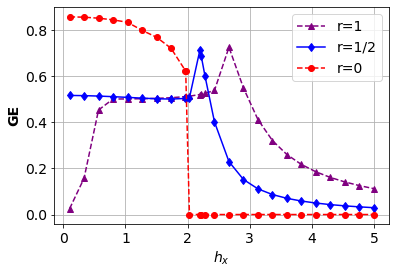

In [10]:
# Plot the results
plt.plot(p_values, optimal_valuesEO3, color='purple', linestyle='--', marker='^', label="r=1")  
plt.plot(p_values, optimal_valuesEO2, 'b-d', label="r=1/2")  
plt.plot(p_values, optimal_valuesEO1, 'r--o', label="r=0")  
plt.xlabel(r"$h_{x}$", fontsize=14, fontweight='bold')
plt.ylabel("GE", fontsize=14, fontweight='bold')
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.show()